# Nonparametric ML Models - Cumulative Lab

## Introduction

In this cumulative lab, you will apply two nonparametric models you have just learned — k-nearest neighbors and decision trees — to the forest cover dataset.

## Objectives

* Practice identifying and applying appropriate preprocessing steps
* Perform an iterative modeling process, starting from a baseline model
* Explore multiple model algorithms, and tune their hyperparameters
* Practice choosing a final model across multiple model algorithms and evaluating its performance

## Your Task: Complete an End-to-End ML Process with Nonparametric Models on the Forest Cover Dataset

![line of pine trees](https://curriculum-content.s3.amazonaws.com/data-science/images/trees.jpg)

Photo by <a href="https://unsplash.com/@michaelbenz?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Michael Benz</a> on <a href="/s/photos/forest?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Business and Data Understanding

To repeat the previous description:

> Here we will be using an adapted version of the forest cover dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/covertype). Each record represents a 30 x 30 meter cell of land within Roosevelt National Forest in northern Colorado, which has been labeled as `Cover_Type` 1 for "Cottonwood/Willow" and `Cover_Type` 0 for "Ponderosa Pine". (The original dataset contained 7 cover types but we have simplified it.)

The task is to predict the `Cover_Type` based on the available cartographic variables:

In [1]:
# Run this cell without changes
import pandas as pd

df = pd.read_csv('data/forest_cover.csv')
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2553,235,17,351,95,780,188,253,199,1410,...,0,0,0,0,0,0,0,0,0,0
1,2011,344,17,313,29,404,183,211,164,300,...,0,0,0,0,0,0,0,0,0,0
2,2022,24,13,391,42,509,212,212,134,421,...,0,0,0,0,0,0,0,0,0,0
3,2038,50,17,408,71,474,226,200,102,283,...,0,0,0,0,0,0,0,0,0,0
4,2018,341,27,351,34,390,152,188,168,190,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38496,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,0
38497,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,0
38498,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,0
38499,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,0


> As you can see, we have over 38,000 rows, each with 52 feature columns and 1 target column:

> * `Elevation`: Elevation in meters
> * `Aspect`: Aspect in degrees azimuth
> * `Slope`: Slope in degrees
> * `Horizontal_Distance_To_Hydrology`: Horizontal dist to nearest surface water features in meters
> * `Vertical_Distance_To_Hydrology`: Vertical dist to nearest surface water features in meters
> * `Horizontal_Distance_To_Roadways`: Horizontal dist to nearest roadway in meters
> * `Hillshade_9am`: Hillshade index at 9am, summer solstice
> * `Hillshade_Noon`: Hillshade index at noon, summer solstice
> * `Hillshade_3pm`: Hillshade index at 3pm, summer solstice
> * `Horizontal_Distance_To_Fire_Points`: Horizontal dist to nearest wildfire ignition points, meters
> * `Wilderness_Area_x`: Wilderness area designation (3 columns)
> * `Soil_Type_x`: Soil Type designation (39 columns)
> * `Cover_Type`: 1 for cottonwood/willow, 0 for ponderosa pine

This is also an imbalanced dataset, since cottonwood/willow trees are relatively rare in this forest:

In [2]:
# Run this cell without changes
print("Raw Counts")
print(df["Cover_Type"].value_counts())
print()
print("Percentages")
print(df["Cover_Type"].value_counts(normalize=True))

Raw Counts
0    35754
1     2747
Name: Cover_Type, dtype: int64

Percentages
0    0.928651
1    0.071349
Name: Cover_Type, dtype: float64


Thus, a baseline model that always chose the majority class would have an accuracy of over 92%. Therefore we will want to report additional metrics at the end.

### Previous Best Model

In a previous lab that used this data, we had SMOTE create additional synthetic data, then tuned the hyperparameters of a logistic regression model to get the following final model metrics:

* **Log loss:** 0.13031294393913376
* **Accuracy:** 0.9456679825472678
* **Precision:** 0.6659919028340081
* **Recall:** 0.47889374090247455

In this lab, you will try to beat those scores using more-complex, nonparametric models.

### Modeling

Although you may be aware of some additional model algorithms available from scikit-learn, this lab focuses on two of them: k-nearest neighbors and decision trees. Here are some reminders about these models:

#### kNN - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

This algorithm — unlike linear models or tree-based models — does not emphasize learning the relationship between the features and the target. Instead, for a given test record, it finds the most similar records in the training set and returns an average of their target values.

* **Training speed:** Fast. In theory it's just saving the training data for later, although the scikit-learn implementation has some additional logic "under the hood" to make prediction faster.
* **Prediction speed:** Very slow. The model has to look at every record in the training set to find the k closest to the new record.
* **Requires scaling:** Yes. The algorithm to find the nearest records is distance-based, so it matters that distances are all on the same scale.
* **Key hyperparameters:** `n_neighbors` (how many nearest neighbors to find; too few neighbors leads to overfitting, too many leads to underfitting), `p` and `metric` (what kind of distance to use in defining "nearest" neighbors)

#### Decision Trees - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Similar to linear models (and unlike kNN), this algorithm emphasizes learning the relationship between the features and the target. However, unlike a linear model that tries to find linear relationships between each of the features and the target, decision trees look for ways to split the data based on features to decrease the entropy of the target in each split.

* **Training speed:** Slow. The model is considering splits based on as many as all of the available features, and it can split on the same feature multiple times. This requires exponential computational time that increases based on the number of columns as well as the number of rows.
* **Prediction speed:** Medium fast. Producing a prediction with a decision tree means applying several conditional statements, which is slower than something like logistic regression but faster than kNN.
* **Requires scaling:** No. This model is not distance-based. You also can use a `LabelEncoder` rather than `OneHotEncoder` for categorical data, since this algorithm doesn't necessarily assume that the distance between `1` and `2` is the same as the distance between `2` and `3`.
* **Key hyperparameters:** Many features relating to "pruning" the tree. By default they are set so the tree can overfit, and by setting them higher or lower (depending on the hyperparameter) you can reduce overfitting, but too much will lead to underfitting. These are: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, and `min_impurity_decrease`. You can also try changing the `criterion` to "entropy" or the `splitter` to "random" if you want to change the splitting logic.

### Requirements

#### 1. Prepare the Data for Modeling

#### 2. Build a Baseline kNN Model

#### 3. Build Iterative Models to Find the Best kNN Model

#### 4. Build a Baseline Decision Tree Model

#### 5. Build Iterative Models to Find the Best Decision Tree Model

#### 6. Choose and Evaluate an Overall Best Model

## 1. Prepare the Data for Modeling

The target is `Cover_Type`. In the cell below, split `df` into `X` and `y`, then perform a train-test split with `random_state=42` and `stratify=y` to create variables with the standard `X_train`, `X_test`, `y_train`, `y_test` names.

Include the relevant imports as you go.

In [4]:
# Your code here
y = df['Cover_Type']
X = df.drop('Cover_Type', axis=1)
#tts
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Now, instantiate a `StandardScaler`, fit it on `X_train`, and create new variables `X_train_scaled` and `X_test_scaled` containing values transformed with the scaler.

In [5]:
# Your code here
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The following code checks that everything is set up correctly:

In [6]:
# Run this cell without changes

# Checking that df was separated into correct X and y
assert type(X) == pd.DataFrame and X.shape == (38501, 52)
assert type(y) == pd.Series and y.shape == (38501,)

# Checking the train-test split
assert type(X_train) == pd.DataFrame and X_train.shape == (28875, 52)
assert type(X_test) == pd.DataFrame and X_test.shape == (9626, 52)
assert type(y_train) == pd.Series and y_train.shape == (28875,)
assert type(y_test) == pd.Series and y_test.shape == (9626,)

# Checking the scaling
assert X_train_scaled.shape == X_train.shape
assert round(X_train_scaled[0][0], 3) == -0.636
assert X_test_scaled.shape == X_test.shape
assert round(X_test_scaled[0][0], 3) == -1.370

## 2. Build a Baseline kNN Model

Build a scikit-learn kNN model with default hyperparameters. Then use `cross_val_score` with `scoring="neg_log_loss"` to find the mean log loss for this model (passing in `X_train_scaled` and `y_train` to `cross_val_score`). You'll need to find the mean of the cross-validated scores, and negate the value (either put a `-` at the beginning or multiply by `-1`) so that your answer is a log loss rather than a negative log loss.

Call the resulting score `knn_baseline_log_loss`.

Your code might take a minute or more to run.

In [10]:
# Replace None with appropriate code

# Relevant imports
from sklearn.model_selection import cross_val_score 
from sklearn.neighbors import KNeighborsClassifier

# Creating the model
knn_baseline_model = KNeighborsClassifier()

#I fit it now, right? <-----sure, but remember this doesn't really do much besides 
# store information - KNN comes alive when we call its predict method. This is why 
# I can include fitting here and it doesn't make a difference.
knn_baseline_model.fit(X_train_scaled, y_train)

# Perform cross-validation
knn_baseline_log_loss = cross_val_score(knn_baseline_model, 
                                        X_train_scaled,
                                        y_train,
                                        scoring="neg_log_loss")

#taking the mean and undoing the negative part
knn_baseline_log_loss = -knn_baseline_log_loss.mean()
knn_baseline_log_loss

0.12964546386734577

Our best logistic regression model had a log loss of 0.13031294393913376

Is this model better? Compare it in terms of metrics and speed.

In [13]:
# Replace None with appropriate text
"""This is a marginal improvement, but an improvement nonetheless. This \
KNN modeling & evaluating process was just a little slow; I think it \
took a couple seconds max."""

'This is a marginal improvement, but an improvement nonetheless. This KNN modeling & evaluating process was just a little slow; I think it took a couple seconds max.'

## 3. Build Iterative Models to Find the Best kNN Model

Build and evaluate at least two more kNN models to find the best one. Explain why you are changing the hyperparameters you are changing as you go. These models will be *slow* to run, so be thinking about what you might try next as you run them.

In [17]:
# Your code here (add more cells as needed)

#Let's iterate through n_neighbors settings:
import numpy as np

k_settings = []
log_loss_scores = []

for i in np.arange(1, 27, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    score = -cross_val_score(knn, 
                             X_train_scaled,
                             y_train,
                             scoring="neg_log_loss").mean()
    k_settings.append(i)
    log_loss_scores.append(score)

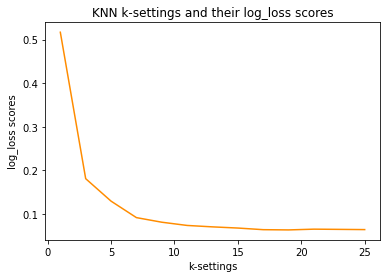

In [20]:
# Your code here (add more cells as needed)

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(k_settings, log_loss_scores, color="darkorange")
ax.set_xlabel("k-settings")
ax.set_ylabel("log_loss scores")
ax.set_title("KNN k-settings and their log_loss scores");

In [21]:
"""Looks like it bottoms out somewhere around n_neighbors = 17, let's check."""

"Looks like it bottoms out somewhere around n_neighbors = 17, let's check."

In [30]:
k_settings_and_log_loss_scores = list(zip(k_settings, log_loss_scores))
sorted(k_settings_and_log_loss_scores, key=lambda x: x[1])

[(19, 0.0636809988068612),
 (17, 0.06423208224775209),
 (25, 0.06441357828070421),
 (23, 0.06492001676623654),
 (21, 0.06541519646671286),
 (15, 0.06795956046304713),
 (13, 0.07066700606679736),
 (11, 0.07392904401138965),
 (9, 0.08133507041269608),
 (7, 0.09188537711305211),
 (5, 0.12964546386734577),
 (3, 0.1811320692968615),
 (1, 0.5167817317089007)]

In [37]:
"""Ah, it's at n_neighbors=19, and that's a pretty good reduction in log_loss. \
Now do I try optimizing another hyperparam with n_neighbors set to 19 or with \
an otherwise vanilla KNN model? I'm gonna say...keep everything else vanilla."""

"Ah, it's at n_neighbors=19, and that's a pretty good reduction in log_loss. Now do I try optimizing another hyperparam with n_neighbors set to 19 or with an otherwise vanilla KNN model? I'm gonna say...keep everything else vanilla."

In [31]:
# Your code here (add more cells as needed)

#Now we shall also try changin' the 'p' (power) hyperparam:
p_settings = []
log_loss_scores = []

for i in np.arange(1, 6):
    knn = KNeighborsClassifier(p=i)
    knn.fit(X_train_scaled, y_train)
    score = -cross_val_score(knn, 
                             X_train_scaled,
                             y_train,
                             scoring="neg_log_loss").mean()
    p_settings.append(i)
    log_loss_scores.append(score)

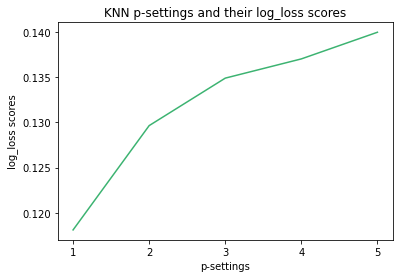

In [35]:
fig, ax = plt.subplots()
ax.plot(p_settings, log_loss_scores, color="mediumseagreen")
plt.xticks(np.arange(1, 6))
ax.set_xlabel("p-settings")
ax.set_ylabel("log_loss scores")
ax.set_title("KNN p-settings and their log_loss scores");

In [36]:
"""Settin' p=1 works best. Lastly, let's see whether changing the weights param helps."""

"Settin' p=1 works best. Lastly, let's see whether changing the weights param helps."

In [38]:
knn_distance_model = KNeighborsClassifier(weights='distance')
knn_distance_model.fit(X_train_scaled, y_train)

# Perform cross-validation
knn_distance_log_loss = -cross_val_score(knn_distance_model, 
                                        X_train_scaled,
                                        y_train,
                                        scoring="neg_log_loss").mean()
knn_distance_log_loss

0.1263839716580628

In [39]:
"""That's better than the baseline. Okay, let's combine the n_neighbors, \
p, and weights params we've found."""

"That's better than the baseline. Okay, let's combine the n_neighbors, p, and weights params we've found."

In [40]:
knn_optimized_model = KNeighborsClassifier(n_neighbors=19,
                                           weights='distance',
                                           p=1)
knn_optimized_model.fit(X_train_scaled, y_train)

# Perform cross-validation
knn_optimized_log_loss = -cross_val_score(knn_optimized_model, 
                                        X_train_scaled,
                                        y_train,
                                        scoring="neg_log_loss").mean()
knn_optimized_log_loss

0.055088794636672614

In [41]:
"""Nice, that's the lowest log_loss so far."""

"Nice, that's the lowest log_loss so far."

## 4. Build a Baseline Decision Tree Model

Now that you have chosen your best kNN model, start investigating decision tree models. First, build and evaluate a baseline decision tree model, using default hyperparameters (with the exception of `random_state=42` for reproducibility).

(Use cross-validated log loss, just like with the previous models.)

In [79]:
# Your code here
from sklearn.tree import DecisionTreeClassifier
#instantiating & fitting the DecisionTreeClassifier model
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)
# Perform cross-validation
dt_baseline_log_loss = -cross_val_score(dt_baseline, 
                                        X_train,
                                        y_train,
                                        scoring="neg_log_loss").mean()
dt_baseline_log_loss

0.7352281158853683

Interpret this score. How does this compare to the log loss from our best logistic regression and best kNN models? Any guesses about why?

In [43]:
# Replace None with appropriate text
"""This is definitely worse than the KNN baseline was, although log_loss \
is a relative metric, so it's still difficult to say just *how* worse it is. \
As to why, I wonder whether it has something to do with the target class \
imbalance; maybe KNN models handle that better with their distance-based metrics."""

"This is definitely worse than the KNN baseline was, although log_loss is a relative metric, so it's still difficult to say just *how* worse it is. As to why, I wonder whether it has something to do with the target class imbalance; maybe KNN models handle that better with their distance-based metrics."

## 5. Build Iterative Models to Find the Best Decision Tree Model

Build and evaluate at least two more decision tree models to find the best one. Explain why you are changing the hyperparameters you are changing as you go.

In [51]:
np.arange(0.1, 0.6, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5])

In [80]:
# Your code here (add more cells as needed)

from imblearn.over_sampling import RandomOverSampler
#placeholder list for log_loss scores
log_loss_scores = []
#defining oversampling strategies
sampling_strategies = np.arange(0.1, 0.6, 0.1)
for i in sampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=42, sampling_strategy=i)
    # fit and apply the transform
    X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)    
    #instantiate & fit the model to X_over & y_over
    dt_oversample_temp = DecisionTreeClassifier(random_state=42)
    dt_oversample_temp.fit(X_train_over, y_train_over)
    # Perform cross-validation
    dt_oversampled_log_loss = -cross_val_score(dt_oversample_temp, 
                                        X_train_over, 
                                        y_train_over,
                                        scoring="neg_log_loss").mean()
    log_loss_scores.append(dt_oversampled_log_loss)

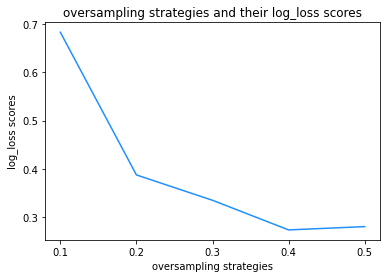

In [81]:
fig, ax = plt.subplots()
ax.plot(sampling_strategies, log_loss_scores, color="dodgerblue")
plt.xticks(sampling_strategies)
ax.set_xlabel("oversampling strategies")
ax.set_ylabel("log_loss scores")
ax.set_title("oversampling strategies and their log_loss scores");

In [82]:
min(log_loss_scores)

0.27363131624541753

In [83]:
"""We can only go so far as 0.5 and it looks like 0.4 is the optimal one \
with a log_loss score of 0.274, but that's nowhere near the KNN models. \
Let's try undersampling, too."""

"We can only go so far as 0.5 and it looks like 0.4 is the optimal one with a log_loss score of 0.276, but that's nowhere near the KNN models. Let's try undersampling, too."

In [57]:
np.arange(0.5, 1.0, 0.1)

array([0.5, 0.6, 0.7, 0.8, 0.9])

In [84]:
from imblearn.under_sampling import RandomUnderSampler
#placeholder list for log_loss scores
log_loss_scores = []
#defining undersampling strategies
sampling_strategies = np.arange(0.5, 1.0, 0.1)
for i in sampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=42, sampling_strategy=i)
    # fit and apply the transform
    X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)    
    #instantiate & fit the model to X_under & y_under
    dt_undersample_temp = DecisionTreeClassifier(random_state=42)
    dt_undersample_temp.fit(X_train_under, y_train_under)
    # Perform cross-validation
    dt_undersampled_log_loss = -cross_val_score(dt_undersample_temp, 
                                        X_train_under, 
                                        y_train_under,
                                        scoring="neg_log_loss").mean()
    log_loss_scores.append(dt_undersampled_log_loss)

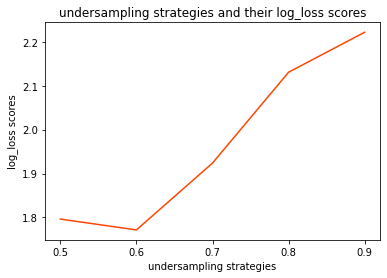

In [85]:
fig, ax = plt.subplots()
ax.plot(sampling_strategies, log_loss_scores, color="orangered")
plt.xticks(sampling_strategies)
ax.set_xlabel("undersampling strategies")
ax.set_ylabel("log_loss scores")
ax.set_title("undersampling strategies and their log_loss scores");

In [86]:
min(log_loss_scores)

1.7716948132873327

In [ ]:
"""Well, that is terrible even at its best, but hey - at least we still have \
the improvement over the decision tree baseline with the oversampling strategy at 0.4. \
Let's also try iterating through the decision tree's max_depth hyperparameter."""

In [87]:
# Your code here (add more cells as needed)

#placeholder list for log_loss scores
log_loss_scores = []
#defining max_depth settings to try
max_depth_settings = np.arange(1,20)
#iterating through them and appending log_loss_scores
for i in max_depth_settings:
    #instantiate & fit the model with the given max_depth param setting
    dt_temp = DecisionTreeClassifier(random_state=42, max_depth=i)
    dt_temp.fit(X_train, y_train)
    # Perform cross-validation
    dt_temp_log_loss = -cross_val_score(dt_temp, 
                                        X_train, 
                                        y_train,
                                        scoring="neg_log_loss").mean()
    log_loss_scores.append(dt_temp_log_loss)

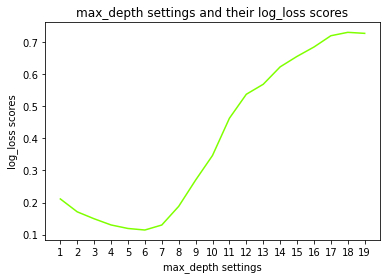

In [88]:
fig, ax = plt.subplots()
ax.plot(max_depth_settings, log_loss_scores, color="chartreuse")
plt.xticks(max_depth_settings)
ax.set_xlabel("max_depth settings")
ax.set_ylabel("log_loss scores")
ax.set_title("max_depth settings and their log_loss scores");

In [89]:
min(log_loss_scores)

0.11456479653138489

In [68]:
"""Wow, a big improvement here when max_depth is set to 6. Let's try \
min_samples_split now."""

"Wow, a big improvement here when max_depth is set to 6. Let's try min_samples_split now."

In [90]:
#placeholder list for log_loss scores
log_loss_scores = []
#defining min_samples_split settings to try
min_samples_split_settings = np.arange(0.1,1.1,0.1)
#iterating through them and appending log_loss_scores
for i in min_samples_split_settings:
    #instantiate & fit the model with the given min_samples_split param setting
    dt_temp = DecisionTreeClassifier(random_state=42, min_samples_split=i)
    dt_temp.fit(X_train, y_train)
    # Perform cross-validation
    dt_temp_log_loss = -cross_val_score(dt_temp, 
                                        X_train, 
                                        y_train,
                                        scoring="neg_log_loss").mean()
    log_loss_scores.append(dt_temp_log_loss)

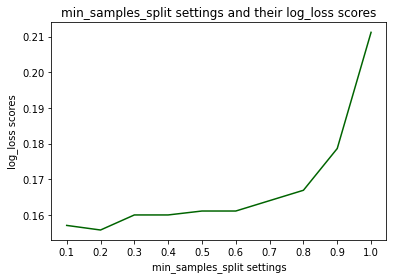

In [91]:
fig, ax = plt.subplots()
ax.plot(min_samples_split_settings, log_loss_scores, color="darkgreen")
plt.xticks(min_samples_split_settings)
ax.set_xlabel("min_samples_split settings")
ax.set_ylabel("log_loss scores")
ax.set_title("min_samples_split settings and their log_loss scores");

In [92]:
min(log_loss_scores)

0.15572847881598556

In [ ]:
"""Setting min_samples_split to 0.2 helped the most, let's finally \
try min_samples_leaf."""

In [93]:
#placeholder list for log_loss scores
log_loss_scores = []
#defining min_samples_leaf settings to try
min_samples_leaf_settings = np.arange(0.1,1.0,0.1)
#iterating through them and appending log_loss_scores
for i in min_samples_leaf_settings:
    #instantiate & fit the model with the given min_samples_leaf param setting
    dt_temp = DecisionTreeClassifier(random_state=42, min_samples_leaf=i)
    dt_temp.fit(X_train, y_train)
    # Perform cross-validation
    dt_temp_log_loss = -cross_val_score(dt_temp, 
                                        X_train, 
                                        y_train,
                                        scoring="neg_log_loss").mean()
    log_loss_scores.append(dt_temp_log_loss)

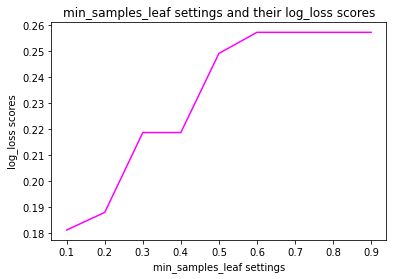

In [94]:
fig, ax = plt.subplots()
ax.plot(min_samples_leaf_settings, log_loss_scores, color="magenta")
plt.xticks(min_samples_leaf_settings)
ax.set_xlabel("min_samples_leaf settings")
ax.set_ylabel("log_loss scores")
ax.set_title("min_samples_leaf settings and their log_loss scores");

In [95]:
"""Setting min_samples_leaf to 0.1 gets us below the baseline, which \
may help. Let's combine them all!"""

"Setting min_samples_leaf to 0.1 gets us below the baseline, which may help. Let's combine them all!"

In [96]:
#set oversampling strategy to 0.4
oversample = RandomOverSampler(random_state=42, sampling_strategy=0.4)
# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)    
#instantiate & fit the model to X_over & y_over
dt_hopefully_optimized = DecisionTreeClassifier(random_state=42, 
                                                max_depth=6,
                                                min_samples_split=0.2,
                                                min_samples_leaf=0.1)
dt_hopefully_optimized.fit(X_train_over, y_train_over)
# Perform cross-validation
dt_hopefully_optimized_log_loss = -cross_val_score(dt_hopefully_optimized, 
                                        X_train_over, 
                                        y_train_over,
                                        scoring="neg_log_loss").mean()
dt_hopefully_optimized_log_loss

0.3176691419145178

In [97]:
"""My God, that is terrible, okay last thing is keeping all those \
hyperparams, but removing the oversampling strategy."""

'My God, that is terrible, okay last thing is keeping all those hyperparams, but removing the oversampling strategy.'

In [98]:
dt_hopefully_optimized = DecisionTreeClassifier(random_state=42, 
                                                max_depth=6,
                                                min_samples_split=0.2,
                                                min_samples_leaf=0.1)
dt_hopefully_optimized.fit(X_train, y_train)
# Perform cross-validation
dt_hopefully_optimized_log_loss = -cross_val_score(dt_hopefully_optimized, 
                                        X_train_over, 
                                        y_train_over,
                                        scoring="neg_log_loss").mean()
dt_hopefully_optimized_log_loss

0.3176691419145178

In [99]:
"""Well, that didn't do anything, so yeah our best d.t. doesn't involve \
any over-or-under-sampling, just setting max_depth to 6, which resulted in \
a log_loss score of 0.1146."""

"Well, that didn't do anything, so yeah our best d.t. doesn't involve any over-or-under-sampling, just setting max_depth to 6, which resulted in a log_loss score of 0.1146."

## 6. Choose and Evaluate an Overall Best Model

Which model had the best performance? What type of model was it?

Instantiate a variable `final_model` using your best model with the best hyperparameters.

In [100]:
# Replace None with appropriate code
final_model = KNeighborsClassifier(n_neighbors=19,
                                   weights='distance',
                                   p=1)
# Fit the model on the full training data
# (scaled or unscaled depending on the model)
final_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=19, p=1, weights='distance')

Now, evaluate the log loss, accuracy, precision, and recall. This code is mostly filled in for you, but you need to replace `None` with either `X_test` or `X_test_scaled` depending on the model you chose.

In [102]:
# Replace None with appropriate code
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss

preds = final_model.predict(X_test_scaled)
probs = final_model.predict_proba(X_test_scaled)

print("log loss: ", log_loss(y_test, probs))
print("accuracy: ", accuracy_score(y_test, preds))
print("precision:", precision_score(y_test, preds))
print("recall:   ", recall_score(y_test, preds))

log loss:  0.059593653805106866
accuracy:  0.9805734469146062
precision: 0.9111842105263158
recall:    0.8064046579330422


Interpret your model performance. How would it perform on different kinds of tasks? How much better is it than a "dummy" model that always chooses the majority class, or the logistic regression described at the start of the lab?

In [103]:
# Replace None with appropriate text
"""Wow, big improvement from the previous lab's Logit model overall. It looks like it would \
do great overall, but only 'pretty good' in terms of avoiding false negatives (recall). \
It's definitely a big improvement over a 'dummy' model that would always predict the \
majority class due to its improved accuracy score."""

"Wow, big improvement from the previous lab's Logit model overall. It looks like it would do great overall, but only 'pretty good' in terms of avoiding false negatives (recall). It's definitely a big improvement over a 'dummy' model that would always predict the majority class due to its improved accuracy score."

## Conclusion

In this lab, you practiced the end-to-end machine learning process with multiple model algorithms, including tuning the hyperparameters for those different algorithms. You saw how nonparametric models can be more flexible than linear models, potentially leading to overfitting but also potentially reducing underfitting by being able to learn non-linear relationships between variables. You also likely saw how there can be a tradeoff between speed and performance, with good metrics correlating with slow speeds.